In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy import integrate
from scipy.interpolate import interp1d
import sys
sys.path.append('../series_alignment')
#sys.path.append('../../../MC-DFM')
#from Scattering_Simulator import pairwise_method  #as pairwise_method
#from gsd import hoomd
from scipy.spatial.transform import Rotation as R
#from apdist.distances import AmplitudePhaseDistance
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.optimize import nnls
import series_alignment
import QENS

c:\Users\htchi\miniconda3\envs\series_distance\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Experimental Data

In [2]:
path_290 = "../Experimental_data/QENS/BASIS_35181_1run_divided_290K.dat"
path_260 = "../Experimental_data/QENS/BASIS_35184_1run_divided_260K.dat"
path_230 = "../Experimental_data/QENS/BASIS_35187_1run_divided_230K.dat"
path_100 = "../Experimental_data/QENS/BASIS_35190_1run_divided_100K.dat"
data_290 = QENS.extract_tagged_dat(path_290)
data_260 = QENS.extract_tagged_dat(path_260)
data_230 = QENS.extract_tagged_dat(path_230)
data_100 = QENS.extract_tagged_dat(path_100)
data_exp_all = [data_230, data_260, data_290]
data_exp_temp = [230, 260, 290]

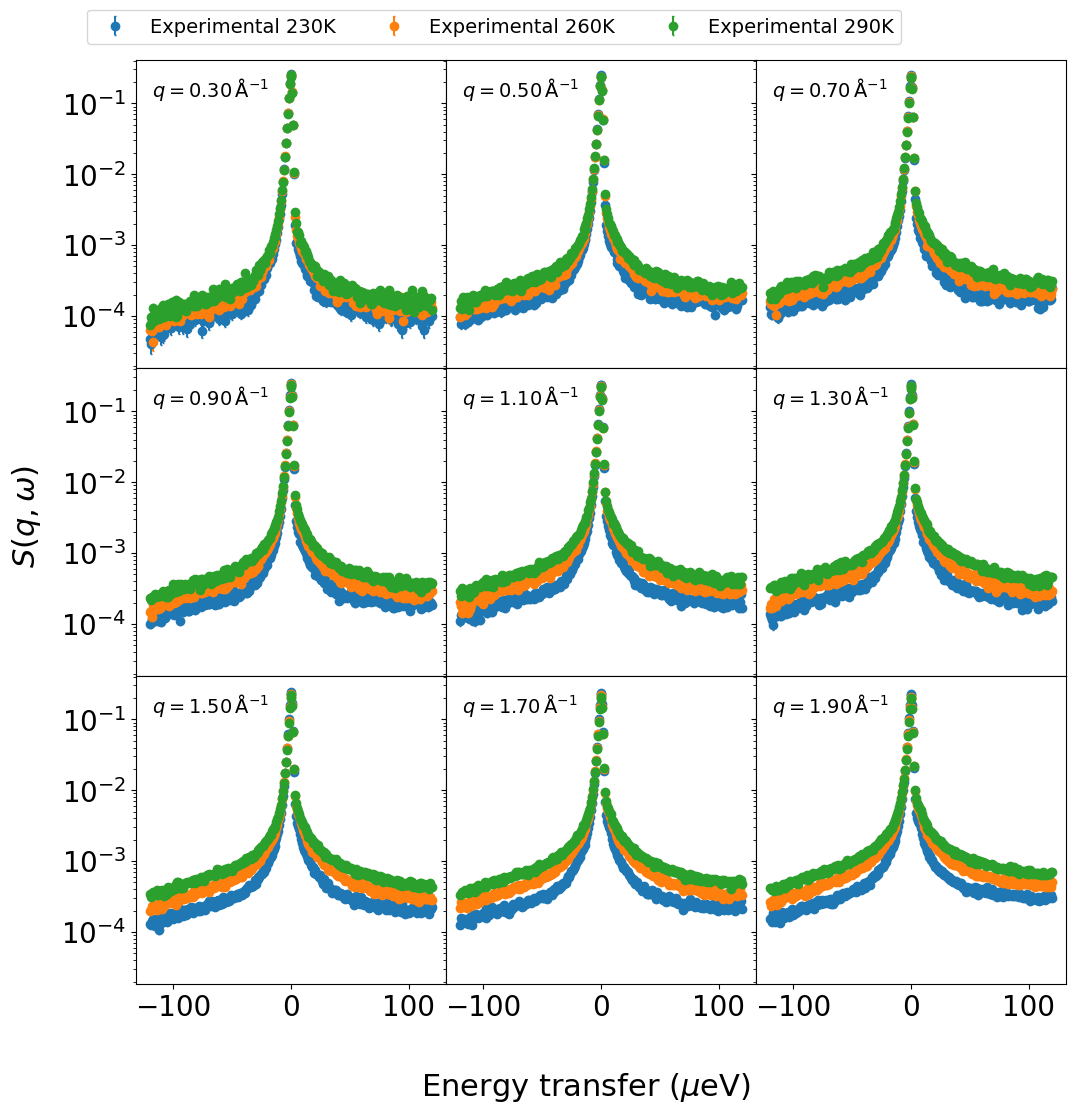

In [3]:
plt.rcParams.update({'font.size': 20})
nrows, ncols = 3, 3
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(12, 12),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for j in range(len(data_exp_all)):
    data = data_exp_all[j]
    for i, ax in enumerate(axes):

        q = data['q (1/Angstrom) values'][i][0]

        # ----- Experimental -----
        area = np.trapezoid(
            data['Energy transfer (micro eV) values'][:, 0],
            data['Group ' + str(i)][:, 0]
        )

        exp_energy = data['Energy transfer (micro eV) values'][:, 0]
        exp_scattering = data['Group ' + str(i)][:, 0] / -area
        exp_uncertainty = data['Group ' + str(i)][:, 1] / -area

        ax.errorbar(
            exp_energy,
            exp_scattering,
            yerr=exp_uncertainty,
            fmt='o',
            linestyle='none',
            capsize=1,
            label='Experimental ' + str(data_exp_temp[j]) + 'K',
            zorder=1,

        )

        ax.set_yscale('log')
        #ax.set_xlim(-100, 100)
        if j == 0:
            ax.text(
            0.05, 0.95,
            rf'$q = {q:.2f}\,\mathrm{{\AA^{{-1}}}}$',
            transform=ax.transAxes,
            fontsize=14,
            va='top',
            ha='left'
        )

#plt.yticks([])
# ----- Global labels -----
fig.supxlabel(r'Energy transfer ($\mu$eV)', fontsize=22)
fig.supylabel(r'$S(q,$$\omega$$)$', fontsize=22)

# ----- Remove gaps & borders -----
plt.subplots_adjust(wspace=0, hspace=0)

# ----- Single legend -----
plt.legend(loc='lower right', bbox_to_anchor=(0.5, 3.02), ncol=3, fontsize=14)
#plt.savefig('../Figures/QENS_Comparison_big_font.png', dpi=600, bbox_inches="tight")
plt.show()


In [4]:
def extract_exp_data(data):
    for i in range(9):
        if i == 0:
            data_exp = np.hstack((data['Energy transfer (micro eV) values'], data['Group 0'][:,0].reshape(-1,1)))
        else:
            data_exp = np.hstack((data_exp, data['Group ' + str(i)][:,0].reshape(-1,1)))
    return data_exp

data_exp_290 = extract_exp_data(data_290)
data_exp_260 = extract_exp_data(data_260)
data_exp_230 = extract_exp_data(data_230)
data_exp_all = [data_exp_230, data_exp_260, data_exp_290]

## Load Simulated Data

In [5]:
data_sim_200 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_200K_2000ps/simulated_sqw_conv_2.csv')
data_sim_230 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_230K_2000ps/simulated_sqw_conv_2.csv')
data_sim_260 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_260K_2000ps/simulated_sqw_conv_2.csv')
data_sim_290 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_290K_2000ps/simulated_sqw_conv_2.csv')
data_sim_320 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_320K_2000ps/simulated_sqw_conv_2.csv')
data_sim_all = [data_sim_200.values, data_sim_230.values, data_sim_260.values, data_sim_290.values, data_sim_320.values]
sim_temps = [200, 230, 260, 290, 320]

In [6]:
# data_sim_320 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_320K_2000ps/simulated_sqw_conv.csv')
# data = data_sim_320.values
# plt.scatter(data[:,0], data[:,6]/data[:,6][0])
# data_sim_320 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_320K_2000ps/simulated_sqw_conv_2.csv')
# data = data_sim_320.values
# plt.scatter(data[:,0], data[:,6]/data[:,6][0])
# plt.yscale('log')
# plt.xlim(-100, 100)

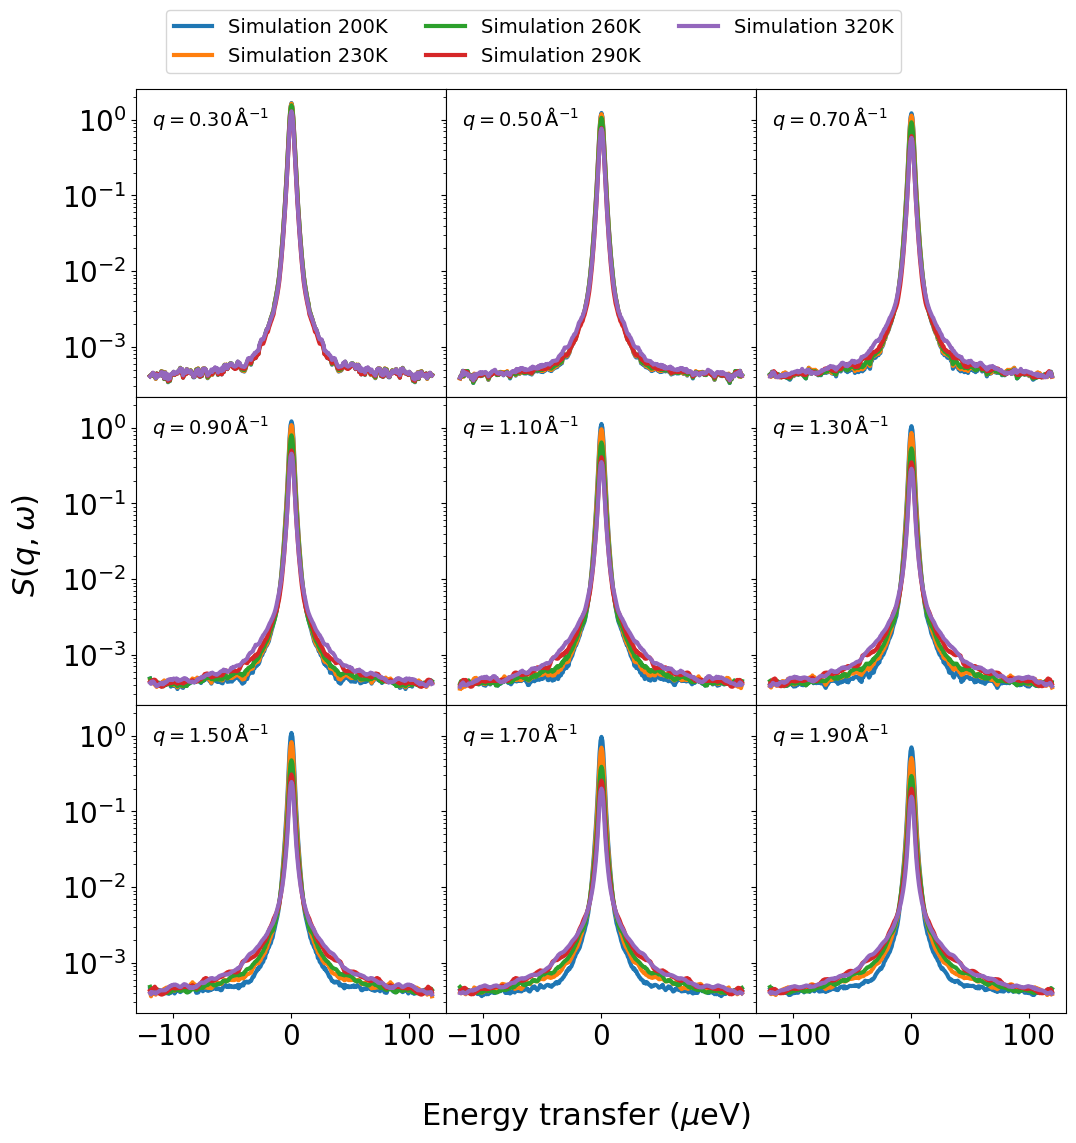

In [7]:
plt.rcParams.update({'font.size': 20})
nrows, ncols = 3, 3
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(12, 12),
    sharex=True,
    sharey=True
)
axes = axes.flatten()
for j in range(len(data_sim_all)):
    data_sim = data_sim_all[j]
    for i, ax in enumerate(axes):
        q = data_sim[:,0]

        # ----- Experimental -----


        # ----- Simulated -----
        area = np.trapezoid(
            data_sim[:,0],
            data_sim[:,i+1]
        )

        sim_energy = data_sim[:,0]
        sim_scattering = data_sim[:,i+1] / -area

        sim_energy_trunc, sim_scattering_trunc = QENS.truncate_simulated_to_experimental(
            exp_energy,
            sim_energy,
            sim_scattering
        )

        sim_scattering_interp = QENS.interpolate_simulated_to_experimental(
            exp_energy,
            sim_energy_trunc,
            sim_scattering_trunc
        )

        normalization_const = np.mean(exp_scattering[0:20]) / np.mean(sim_scattering_interp[0:20])
        sim_scattering_interp *= normalization_const

        ax.plot(
            exp_energy,
            sim_scattering_interp,
            linewidth=3,
            label='Simulation ' + str(sim_temps[j]) + 'K',
            zorder=3,
        )

        ax.set_yscale('log')
        #ax.set_xlim(-100, 100)
        q = data_100['q (1/Angstrom) values'][i][0]
        if j == 0:
            ax.text(
            0.05, 0.95,
            rf'$q = {q:.2f}\,\mathrm{{\AA^{{-1}}}}$',
            transform=ax.transAxes,
            fontsize=14,
            va='top',
            ha='left'
            )
#plt.yticks([])
# ----- Global labels -----
fig.supxlabel(r'Energy transfer ($\mu$eV)', fontsize=22)
fig.supylabel(r'$S(q,$$\omega$$)$', fontsize=22)

# ----- Remove gaps & borders -----
plt.subplots_adjust(wspace=0, hspace=0)

# ----- Single legend -----
plt.legend(loc='lower right', bbox_to_anchor=(0.5, 3.02), ncol=3, fontsize=14)
#plt.savefig('../Figures/QENS_Comparison_big_font.png', dpi=600, bbox_inches="tight")
plt.show()


## Prepare Data

In [8]:
score_matrix = series_alignment.create_distance_matrix(data_exp_all, data_sim_all, 'log_mse')

In [9]:
idx_cols, total_dist = series_alignment.align_monotone_min(score_matrix)

## Compare Curves by Plotting

In [10]:
sim_temps

[200, 230, 260, 290, 320]

In [11]:
idx_cols

[np.int64(2), np.int64(3), 4]

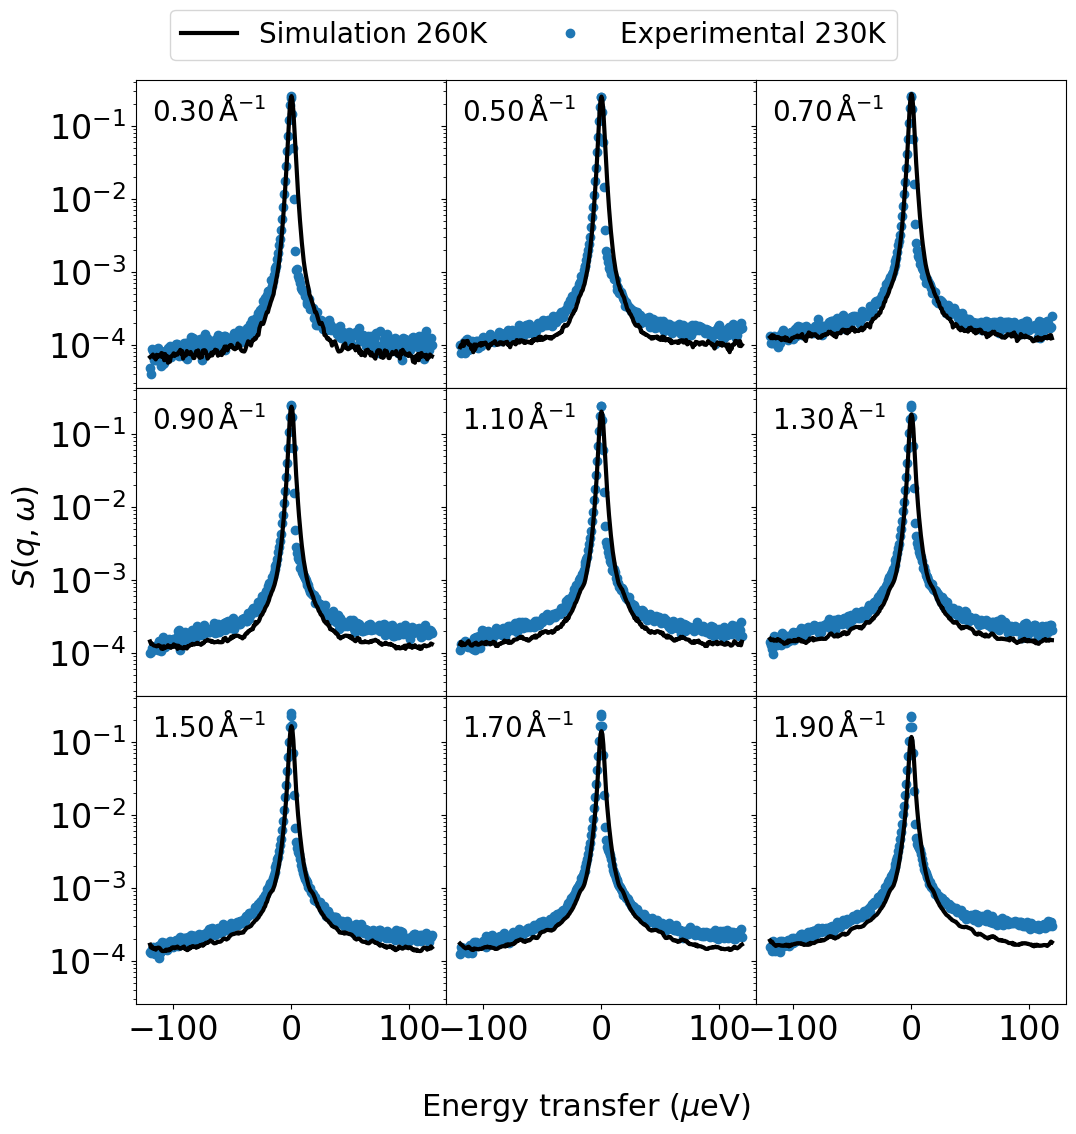

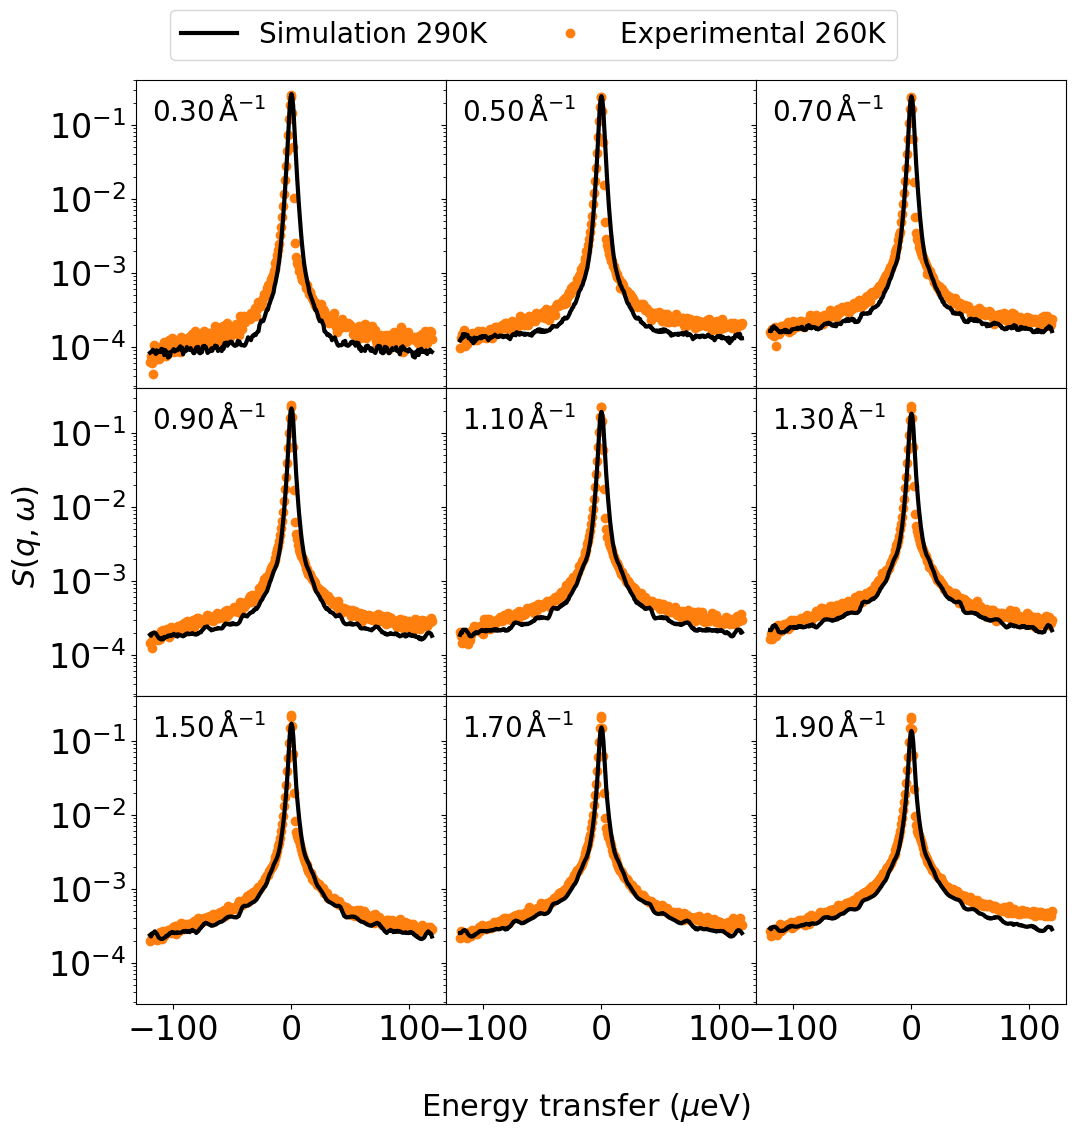

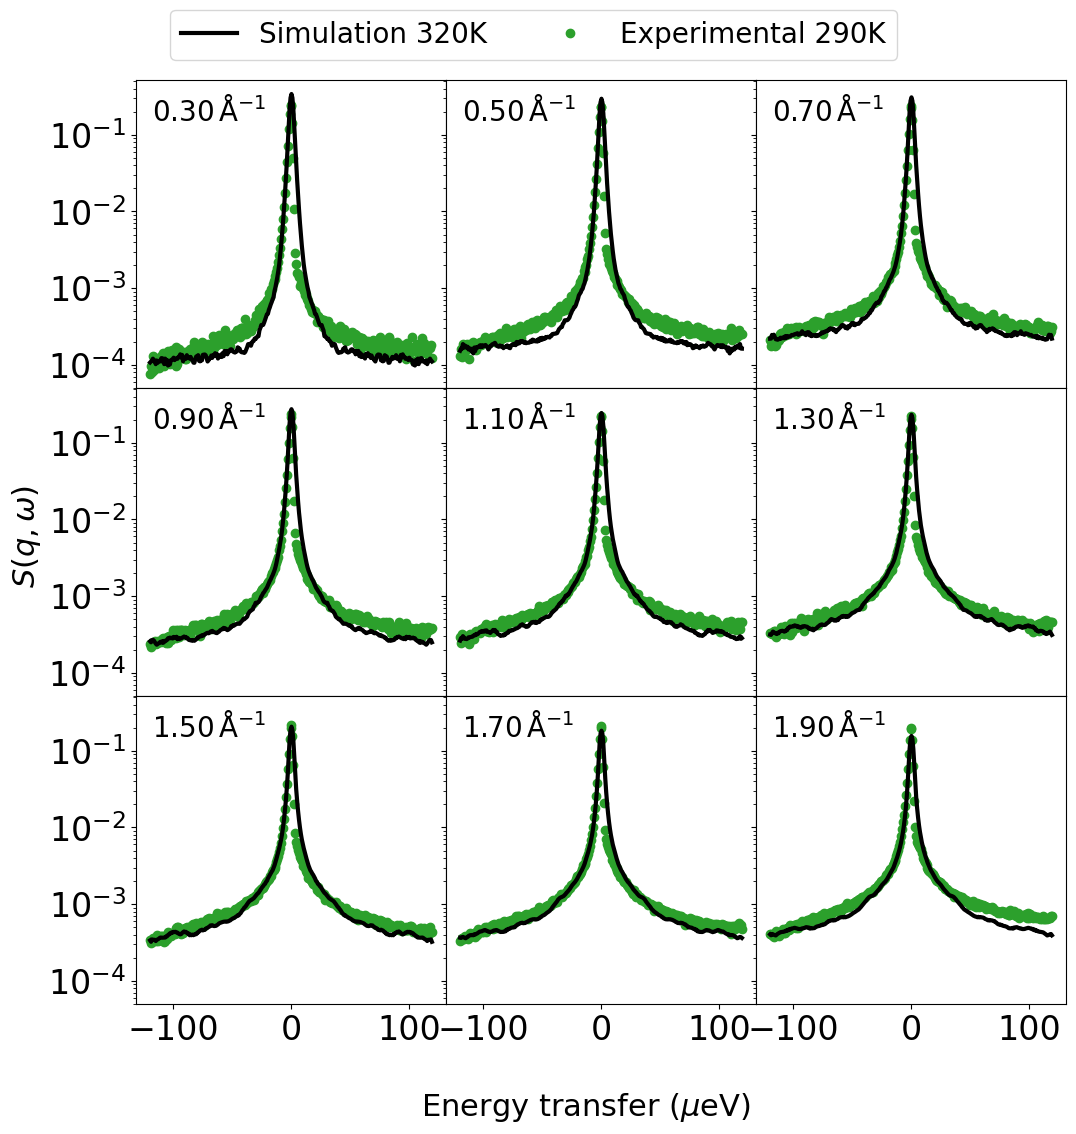

In [12]:
plt.rcParams.update({'font.size': 24})
for j in range(len(idx_cols)):
    nrows, ncols = 3, 3
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(12, 12),
        sharex=True,
        sharey=True
    )
    axes = axes.flatten()
    data_sim = data_sim_all[idx_cols[j]]
    for i, ax in enumerate(axes):
        q = data_sim[:,0]

        # ----- Experimental -----
        data = data_exp_all[j]
        area = np.trapezoid(
        data[:, 0],
        data[:, i+1]
        )

        exp_energy = data[:, 0]
        exp_scattering = data[:, i+1] / -area

        ax.errorbar(
            exp_energy,
            exp_scattering,
            fmt='o',
            linestyle='none',
            capsize=1,
            label='Experimental ' + str(data_exp_temp[j]) + 'K',
            zorder=1,
            color = 'C' + str(j)

        )

        # ----- Simulated -----
        area = np.trapezoid(
            data_sim[:,0],
            data_sim[:,i+1]
        )

        sim_energy = data_sim[:,0]
        sim_scattering = data_sim[:,i+1] / -area

        sim_energy_trunc, sim_scattering_trunc = QENS.truncate_simulated_to_experimental(
            exp_energy,
            sim_energy,
            sim_scattering
        )

        sim_scattering_interp = QENS.interpolate_simulated_to_experimental(
            exp_energy,
            sim_energy_trunc,
            sim_scattering_trunc
        )

        normalization_const = np.mean(exp_scattering[0:20]) / np.mean(sim_scattering_interp[0:20])
        sim_scattering_interp *= normalization_const

        ax.plot(
            exp_energy,
            sim_scattering_interp,
            linewidth=3,
            label='Simulation ' + str(sim_temps[idx_cols[j]]) + 'K',
            color='k',
            zorder=3,
        )

        ax.set_yscale('log')
        #ax.set_xlim(-100, 100)
        q = data_100['q (1/Angstrom) values']
        ax.text(
        0.05, 0.95,
        rf'${q[i][0]:.2f}\,\mathrm{{\AA^{{-1}}}}$',
        transform=ax.transAxes,
        fontsize=20,
        va='top',
        ha='left'
        )
    
    
    #ax.set_axis('off')
    #plt.yticks([])
    # ----- Global labels -----
    fig.supxlabel(r'Energy transfer ($\mu$eV)', fontsize=22)
    fig.supylabel(r'$S(q,$$\omega$$)$', fontsize=22)

    # ----- Remove gaps & borders -----
    plt.subplots_adjust(wspace=0, hspace=0)

    # ----- Single legend -----
    plt.legend(loc='lower right', bbox_to_anchor=(0.5, 3.02), ncol=3, fontsize=20)
    #plt.savefig('../Figures/QENS_Comparison__fig' + str(j) + '.png', dpi=600, bbox_inches="tight")
    plt.show()
